# Michael Schor Notebook

## Dependencies

In [1]:
!pip install pillow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
train_data_dir = 'ZhangLabData/CellData/chest_xray/train'
test_data_dir = 'ZhangLabData/CellData/chest_xray/test'

#Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
       test_data_dir, 
       target_size=(64, 64), batch_size=132)

#Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
       train_data_dir, 
       target_size=(64, 64), batch_size=790)

#Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


## Create validation set from training set

In [3]:
X = train_images
y = train_labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

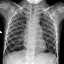

In [4]:
array_to_img(train_images[0])

In [5]:
print(train_labels[0])

[1. 0.]


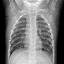

In [6]:
array_to_img(train_images[90])

In [7]:
print(train_labels[90])

[1. 0.]


In [9]:
print('train images shape: ',np.shape(X_train))
print('train labels shape: ',np.shape(y_train))
print('test images shape: ',np.shape(X_val))
print('test labels shape: ',np.shape(y_val))

train images shape:  (632, 64, 64, 3)
train labels shape:  (632, 2)
test images shape:  (158, 64, 64, 3)
test labels shape:  (158, 2)


In [10]:
#train set
X_train_unrow = X_train.reshape(632, -1)
X_train_unrow.shape

(632, 12288)

In [11]:
#test set
X_val_unrow = X_val.reshape(158, -1)
X_val_unrow.shape

(158, 12288)

In [12]:
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [13]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [14]:
#training set
y_train_labels_final = np.reshape(y_train[:,0], (632,1))

In [15]:
np.shape(y_train_labels_final)

(632, 1)

In [16]:
y_val_labels_final = np.reshape(y_val[:,0], (158,1))

In [18]:
np.shape(y_val_labels_final) 

(158, 1)

In [19]:
#scaling the data
X_train_img_final = X_train_unrow/255
X_val_img_final = X_val_unrow/255

type(X_val_img_final)

numpy.ndarray

In [20]:
print(X_train_img_final.shape)
print(X_val_img_final.shape)

(632, 12288)
(158, 12288)


## Baseline Model

In [21]:
np.random.seed(42)
model = models.Sequential()
model.add(layers.Dense(63, activation='tanh', input_shape=(12288,)))
model.add(layers.Dense(42, activation='tanh'))
model.add(layers.Dense(21, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid')) #output layer, binary classification

In [22]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_train_img_final,
                    y_train_labels_final,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val_img_final, y_val_labels_final))

Epoch 1/50
20/20 [==============================] - 0s 10ms/step - loss: 0.5969 - accuracy: 0.7168 - val_loss: 0.4976 - val_accuracy: 0.7848
Epoch 2/50
20/20 [==============================] - 0s 3ms/step - loss: 0.5305 - accuracy: 0.7326 - val_loss: 0.5064 - val_accuracy: 0.7848
Epoch 3/50
20/20 [==============================] - 0s 3ms/step - loss: 0.5117 - accuracy: 0.7500 - val_loss: 0.4582 - val_accuracy: 0.7848
Epoch 4/50
20/20 [==============================] - 0s 3ms/step - loss: 0.5000 - accuracy: 0.7453 - val_loss: 0.4186 - val_accuracy: 0.7848
Epoch 5/50
20/20 [==============================] - 0s 3ms/step - loss: 0.4775 - accuracy: 0.7785 - val_loss: 0.3934 - val_accuracy: 0.9304
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.4169 - accuracy: 0.8244 - val_loss: 0.4584 - val_accuracy: 0.7848
Epoch 7/50
20/20 [==============================] - 0s 3ms/step - loss: 0.4515 - accuracy: 0.8212 - val_loss: 0.3199 - val_accuracy: 0.9304
Epoch 8/50
20/20 [=

In [23]:
results_train = model.evaluate(X_train_img_final, y_train_labels_final)

20/20 [==============================] - 0s 1ms/step - loss: 0.1011 - accuracy: 0.9684


In [24]:
results_val = model.evaluate(X_val_img_final, y_val_labels_final)

5/5 [==============================] - 0s 1ms/step - loss: 0.1169 - accuracy: 0.9620


#### Training accuracy = 0.9797. Test acc = 0.8030. Subsequent models must improve these thresholds.

In [25]:
#plot acc vs loss for train and test set
def visualize_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show();

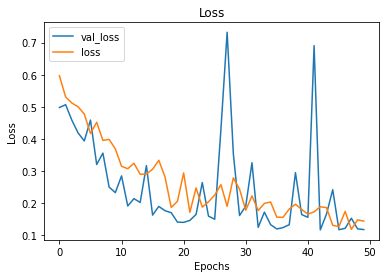

In [26]:
visualize_results(results)

Insight: according to the Loss plot, there is significant overfitting of the model due to the high variation of the validation curve, as well as the divergence of the two curves themselves. Any subsequent models must reduce the variance and overfitting of the baseline model.

For CNN: create convolution filter, padding (and maybe striding?) and pooling layer (if there are too many features)

In [27]:
np.random.seed(42)
model2 = models.Sequential()
model2.add(layers.Dense(63, activation='softmax', input_shape=(12288,)))
model2.add(layers.Dense(42, activation='softmax'))
model2.add(layers.Dense(21, activation='softmax'))
model2.add(layers.Dense(1, activation='sigmoid')) #output layer, binary classification

In [28]:
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results2 = model2.fit(X_train_img_final,
                    y_train_labels_final,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val_img_final, y_val_labels_final))

Epoch 1/50
20/20 [==============================] - 0s 7ms/step - loss: 0.6868 - accuracy: 0.7358 - val_loss: 0.6785 - val_accuracy: 0.7848
Epoch 2/50
20/20 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.7358 - val_loss: 0.6662 - val_accuracy: 0.7848
Epoch 3/50
20/20 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.7358 - val_loss: 0.6552 - val_accuracy: 0.7848
Epoch 4/50
20/20 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.7358 - val_loss: 0.6451 - val_accuracy: 0.7848
Epoch 5/50
20/20 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.7358 - val_loss: 0.6359 - val_accuracy: 0.7848
Epoch 6/50
20/20 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.7358 - val_loss: 0.6276 - val_accuracy: 0.7848
Epoch 7/50
20/20 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.7358 - val_loss: 0.6199 - val_accuracy: 0.7848
Epoch 8/50
20/20 [==

In [29]:
results_train2 = model2.evaluate(X_train_img_final, y_train_labels_final)

20/20 [==============================] - 0s 1ms/step - loss: 0.5787 - accuracy: 0.7358


In [30]:
results_val2 = model2.evaluate(X_val_img_final, y_val_labels_final)

5/5 [==============================] - 0s 819us/step - loss: 0.5338 - accuracy: 0.7848


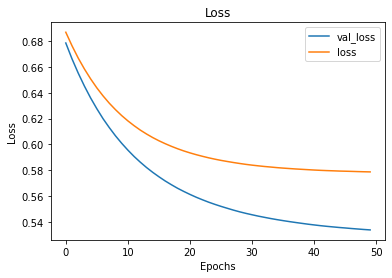

In [31]:
visualize_results(results2)